In [1]:
# !pip install wandb
# !wandb login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
personal_key_for_api  = user_secrets.get_secret("wandb-key")
!wandb login $personal_key_for_api

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import numpy as np
import pandas as pd
import json
import os
import shutil
import glob
import cv2
import matplotlib.pyplot as plt

In [3]:
if not os.path.exists('./masks'):
    os.mkdir('./masks')
if not os.path.exists('./labels'):
    os.mkdir('./labels')

In [4]:
images_path = '../input/nenets-walruses/Датасет/images'
markup_path = '../input/nenets-walruses/Датасет/markup'

images = sorted(glob.glob(images_path+'/*.jpg'))
markups = [filename.replace('images', 'markup').replace('jpg', 'json') for filename in images]
im_mark_pairs = list(zip(images, markups))
len(images), len(markups)

(200, 200)

In [5]:
with open(im_mark_pairs[0][1]) as f:
    markup_example = json.load(f)

In [6]:
for i, individual in enumerate(markup_example):
    print(individual['bbox'])
    if i == 3:
        break
# верхний левый (x1, y1), ширина, высота

[280.5, 112.5, 40.0, 43.0, 0.0]
[661.5, 154.5, 23.0, 27.0, 0.0]
[915.5, 153.5, 20.0, 30.0, 0.0]
[1039.5, 170.5, 34.0, 32.0, 0.0]


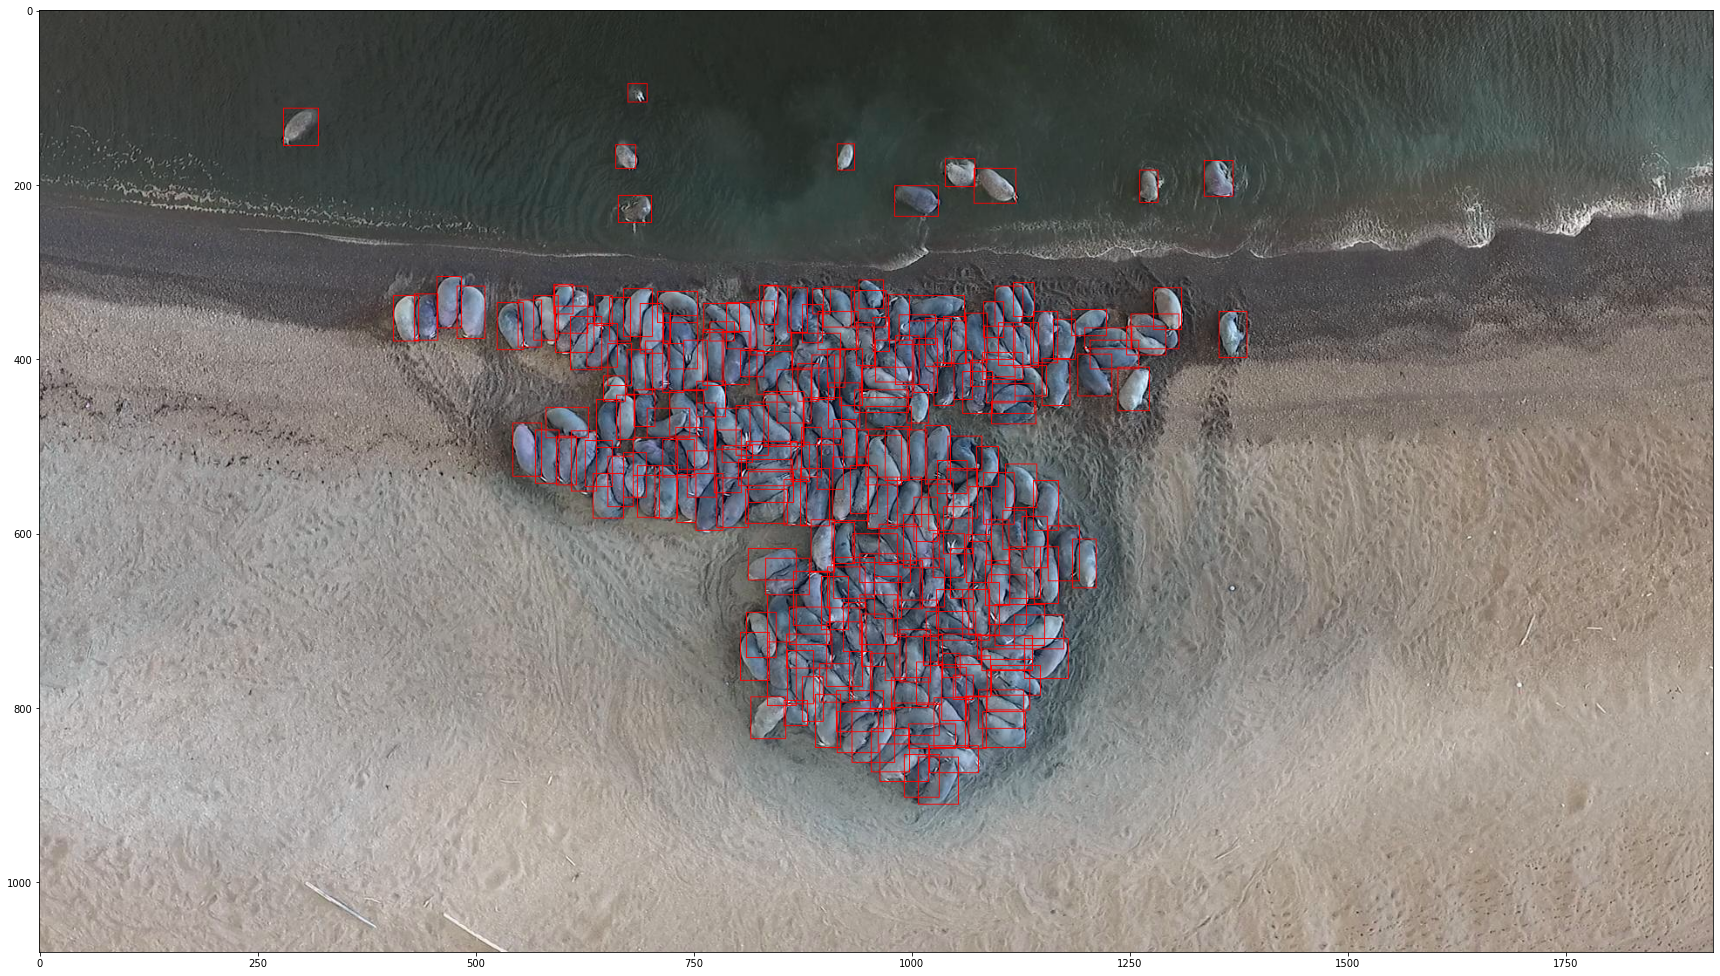

In [7]:
image_example = cv2.imread(im_mark_pairs[0][0])

for item in markup_example:
    x1 = np.int32(item['bbox'][0])
    y1 = np.int32(item['bbox'][1])
    w = np.int32(item['bbox'][2])
    h = np.int32(item['bbox'][3])
    image_example = cv2.rectangle(image_example, (x1, y1), (x1+w, y1+h), (255,0,0), 1)

plt.figure(figsize=(30, 20))
plt.imshow(image_example)

In [8]:
# yolo
# class x_center y_center width height (normilized)
img_bbox_rows = ''

for item in markup_example:
    x1 = item['bbox'][0]
    y1 = item['bbox'][1]
    w = item['bbox'][2]
    h = item['bbox'][3]
    
    img_h = image_example.shape[0]
    img_w = image_example.shape[1]
    
    class_ = 0
    width = w / img_w
    height = h / img_h
    x_center = x1/img_w + (width/2)
    y_center = y1/img_h + (height/2)
    
    str_row = f'{class_} {round(x_center, 4)} {round(y_center, 4)} {round(width, 4)} {round(height, 4)} \n'
    img_bbox_rows = f'{img_bbox_rows}{str_row}'
    
image_file_name = im_mark_pairs[0][0].split('/')[-1]
label_file_name = image_file_name.replace('jpg', 'txt')
with open(f'./labels/{label_file_name}', 'w') as f:
    f.write(img_bbox_rows)

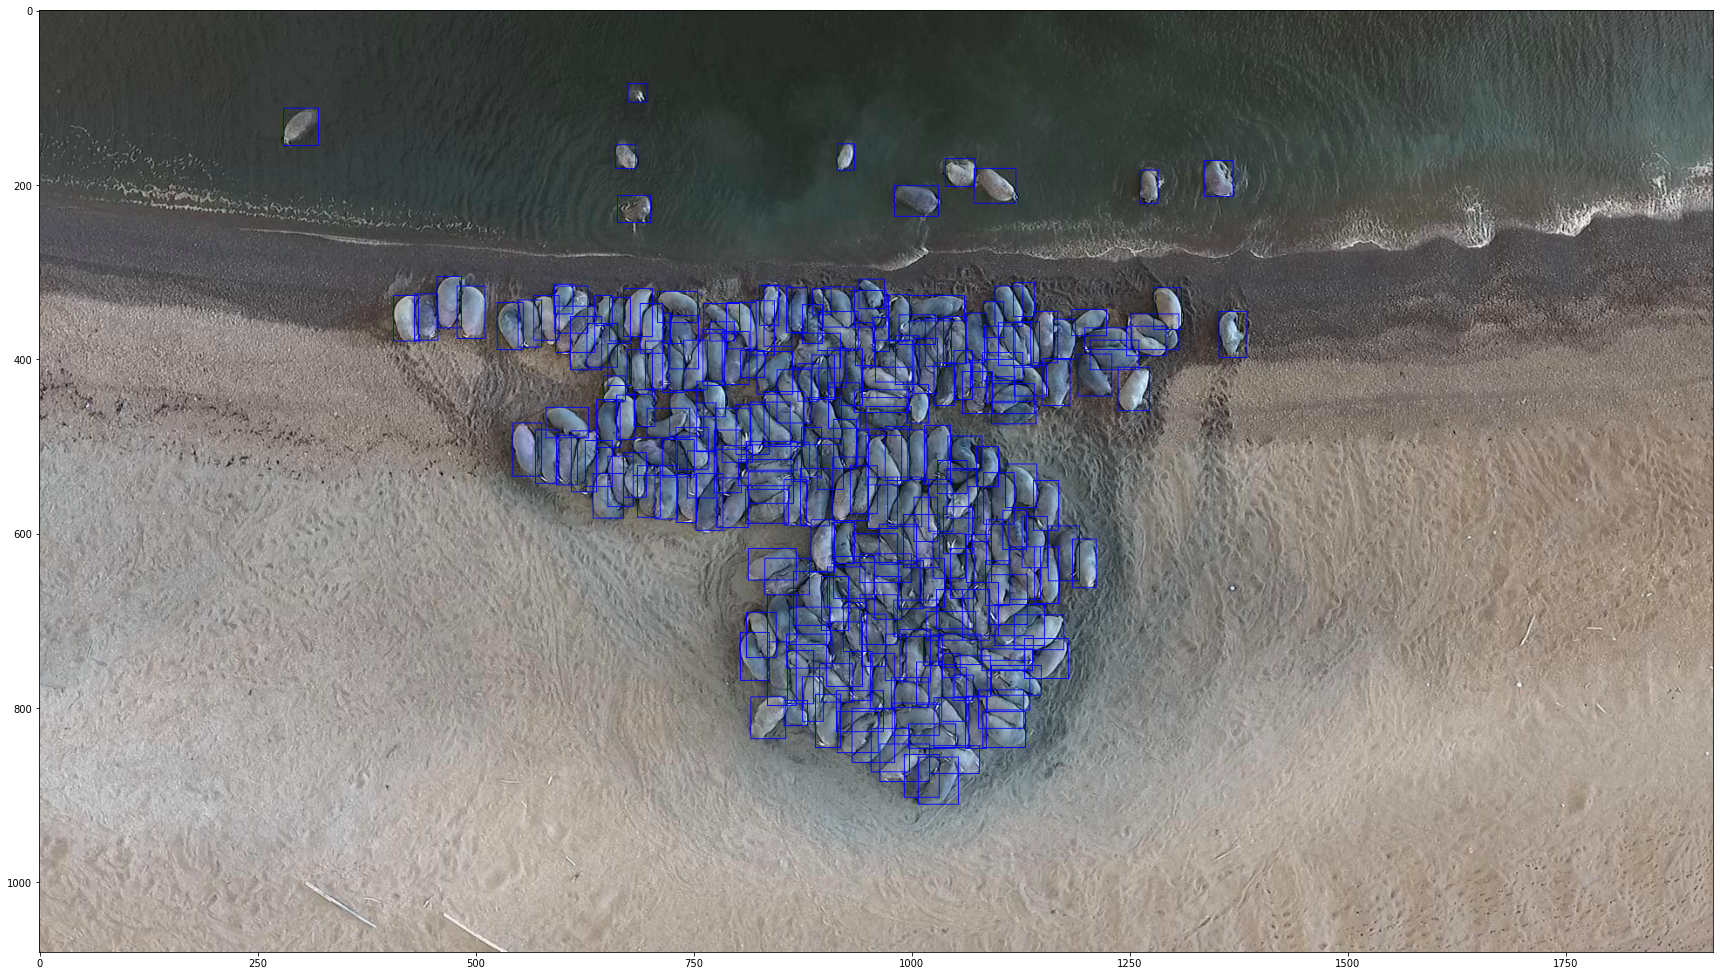

In [9]:
# try parse our yolo annotations

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(im_mark_pairs[0][0])
dh, dw, _ = img.shape

fl = open(f'./labels/{label_file_name}', 'r')
data = fl.readlines()
fl.close()

for dt in data:

    # Split string to float
    _, x, y, w, h = map(float, dt.split())

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.figure(figsize=(30, 20))
plt.imshow(img)
plt.show()

In [10]:
def yolo_to_box_coord(img, str_):
    dh, dw, _ = img.shape
    _, x, y, w, h = map(float, dt.split())
    
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

In [11]:
def yolo_to_center_coord(img, str_):
    dh, dw, _ = img.shape
    _, x, y, w, h = map(float, dt.split())
    
    return dw / x, dh, y

all files, lables

In [12]:
for im_mask_pair in im_mark_pairs:
    image_example = cv2.imread(im_mask_pair[0])
    
    with open(im_mask_pair[1]) as f:
        markup_example = json.load(f)
    
    img_bbox_rows = ''

    for item in markup_example:
        x1 = item['bbox'][0]
        y1 = item['bbox'][1]
        w = item['bbox'][2]
        h = item['bbox'][3]

        img_h = image_example.shape[0]
        img_w = image_example.shape[1]

        class_ = 0
        width = w / img_w
        height = h / img_h
        x_center = x1/img_w + (width/2)
        y_center = y1/img_h + (height/2)

        str_row = f'{class_} {round(x_center, 4)} {round(y_center, 4)} {round(width, 4)} {round(height, 4)} \n'
        img_bbox_rows = f'{img_bbox_rows}{str_row}'
        
    image_file_name = im_mask_pair[0].split('/')[-1]
    label_file_name = image_file_name.replace('jpg', 'txt')
    
    with open(f'./labels/{label_file_name}', 'w') as f:
        f.write(img_bbox_rows)

In [13]:
!ls labels

 104.txt	     'DJI_0022 (4).txt'
 11.txt		     'DJI_0022 (5).txt'
 113.txt	      DJI_0022.txt
 128.txt	     'DJI_0023 (2).txt'
 13.txt		     'DJI_0023 (4).txt'
 132.txt	     'DJI_0023 (5).txt'
 135.txt	      DJI_0023.txt
 137.txt	     'DJI_0024 (3).txt'
 139.txt	     'DJI_0024 (4).txt'
 140.txt	      DJI_0024.txt
 147.txt	     'DJI_0025 (3).txt'
 152.txt	      DJI_0025.txt
 156.txt	     'DJI_0026 (2).txt'
 17.txt		      DJI_0026.txt
 172.txt	     'DJI_0034 (2).txt'
 178.txt	      DJI_0034.txt
 184.txt	     'DJI_0035 (3).txt'
 190.txt	      DJI_0035.txt
 191.txt	     'DJI_0036 (2).txt'
 199.txt	      DJI_0036.txt
 20.txt		     'DJI_0037 (2).txt'
 203.txt	     'DJI_0038 (2).txt'
 206.txt	     'DJI_0038 (3).txt'
 31.txt		      DJI_0038.txt
 33.txt		     'DJI_0039 (3).txt'
 34.txt		      DJI_0039.txt
 39.txt		     'DJI_0040 (2).txt'
 41.txt		      DJI_0040.txt
 42.txt		      DJI_0041.txt
 43.txt		     'DJI_0042 (2).txt'
 47.txt		      DJI_0042.txt
 49.txt		      DJI_0043.txt
 59.txt		     

In [14]:
# !cat ./labels/104.txt
!zip -r labels.zip ./labels

  adding: labels/ (stored 0%)
  adding: labels/61.txt (deflated 69%)
  adding: labels/190.txt (deflated 67%)
  adding: labels/128.txt (deflated 68%)
  adding: labels/82.txt (deflated 69%)
  adding: labels/DJI_0042 (2).txt (deflated 68%)
  adding: labels/DJI_0044.txt (deflated 69%)
  adding: labels/DJI_0004.txt (deflated 70%)
  adding: labels/DJI_0035 (3).txt (deflated 69%)
  adding: labels/screen_4023904df70453db_1626582973984.txt (deflated 69%)
  adding: labels/screen_dab9010251663dc8_1626582975354.txt (deflated 69%)
  adding: labels/DJI_0022 (5).txt (deflated 71%)
  adding: labels/DJI_0006.txt (deflated 71%)
  adding: labels/42.txt (deflated 68%)
  adding: labels/DJI_0110.txt (deflated 68%)
  adding: labels/DJI_0022 (2).txt (deflated 71%)
  adding: labels/DJI_0002 (2).txt (deflated 69%)
  adding: labels/DJI_0088.txt (deflated 69%)
  adding: labels/84.txt (deflated 68%)
  adding: labels/DJI_0063.txt (deflated 69%)
  adding: labels/org_b15f96c438ee8c74_1626434074000.txt (deflated 67%)


Create val

In [15]:
os.mkdir('./val')
os.mkdir('./val/images')
os.mkdir('./val/labels')

In [16]:
!mkdir ./dataset
!cp -r ../input/nenets-walruses/Датасет/* ./dataset
!cp -r ./labels ./dataset

Yolo

In [18]:
idxs_rnd = np.random.choice(200, 30, replace=False)

In [19]:
for idx in idxs_rnd:
    shutil.copy2(im_mark_pairs[idx][0], './val/images')
    shutil.copy2(im_mark_pairs[idx][1].replace('../input/nenets-walruses/Датасет/markup', './labels').replace('json', 'txt'), './val/labels')

In [20]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 12088, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 12088 (delta 21), reused 16 (delta 7), pack-reused 12047
Receiving objects: 100% (12088/12088), 11.92 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (8379/8379), done.
/kaggle/working/yolov5
/kaggle/working


In [21]:
yaml_file = "./yolov5/data/animal.yaml"
train_images_dir = os.path.join('/kaggle/working', 'dataset/', 'images')
val_images_dir = os.path.join('/kaggle/working', 'val/', 'images')

In [22]:
with open(yaml_file, "w") as wobj:
    wobj.write("train: %s\n"%train_images_dir)
    wobj.write("val: %s\n"%val_images_dir)
    wobj.write("nc: %d\n"%1)

In [ ]:
!cat ./yolov5/data/animal.yaml

In [ ]:
# !ls /kaggle/working/val/labels

In [ ]:
# !python yolov5/train.py --img 512 --batch 8 --epochs 20 --data ./yolov5/data/animal.yaml --weights yolov5s.pt
# !python yolov5/train.py --img 512 --batch 8 --epochs 60 --data ./yolov5/data/animal.yaml --weights ./yolov5/runs/train/exp/weights/best.pt

In [25]:
!python yolov5/train.py --img 512 --batch 8 --epochs 30 --data ./yolov5/data/animal.yaml --weights ./best.pt

wandb: Currently logged in as: dimka11. Use `wandb login --relogin` to force relogin
train: weights=./best.pt, cfg=, data=./yolov5/data/animal.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-233-g7433d38 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5

detect test

In [ ]:
!python ./yolov5/detect.py --weights ./yolov5/runs/train/exp3/weights/best.pt --img 640 --conf 0.25 --source ../input/kopter-done/kopter_done_22_04/images --name yolo_test_images_detect --save-txt

In [ ]:
!ls yolov5/runs/detect/yolo_test_images_detect/

In [ ]:
!cat 'yolov5/runs/detect/yolo_test_images_detect/labels/DJI_0001 (2).txt'

In [ ]:
image_test_detect = cv2.imread('yolov5/runs/detect/yolo_test_images_detect/DJI_0001 (3).JPG')

plt.figure(figsize=(30, 20))
plt.imshow(image_test_detect)

In [ ]:
!ls yolov5/runs/train/exp/weights

In [ ]:
# detections_dir = "./yolov5/runs/detect/yolo_test_images_detect/"
# detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

# random_detection_image = Image.open(random.choice(detection_images))
# plt.imshow(np.array(random_detection_image))

In [ ]:
# import torch
    
# model = torch.hub.load('ultralytics/yolov5', 'custom', path_or_model='./yolov5/runs/train/exp1/weights/best.pt')
# model = model.autoshape()

# image_test = cv2.imread('../input/kopter-done/kopter_done_22_04/images/DJI_0001 (2).JPG')

# # boxes = results.pandas().xyxy[0]

# predictions = model("../input/kopter-done/kopter_done_22_04/images", size=512)
# print(predictions)

In [ ]:
# input_images = "../input/kopter-done/kopter_done_22_04/images"
# results = model(input_images)
# labels, cord_thres = results.xyxyn[0][:, -1].numpy(), results.xyxyn[0][:, :-1].numpy()

In [28]:
!cp ./yolov5/runs/train/exp2/weights/best.pt ./
# !ls